In [1]:
!pip install deap

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 136.0/136.0 kB 5.1 MB/s eta 0:00:00


Carregando e prÃ©-processando imagem...
Executando algoritmo de Gerchberg-Saxton...
 	IteraÃ§Ã£o GS (X) 10/200, CorrelaÃ§Ã£o: 0.9580
 	IteraÃ§Ã£o GS (X) 20/200, CorrelaÃ§Ã£o: 0.9662
 	IteraÃ§Ã£o GS (X) 30/200, CorrelaÃ§Ã£o: 0.9696
 	IteraÃ§Ã£o GS (X) 40/200, CorrelaÃ§Ã£o: 0.9715
 	IteraÃ§Ã£o GS (X) 50/200, CorrelaÃ§Ã£o: 0.9725
 	IteraÃ§Ã£o GS (X) 60/200, CorrelaÃ§Ã£o: 0.9728
 	IteraÃ§Ã£o GS (X) 70/200, CorrelaÃ§Ã£o: 0.9738
 	IteraÃ§Ã£o GS (X) 80/200, CorrelaÃ§Ã£o: 0.9743
 	IteraÃ§Ã£o GS (X) 90/200, CorrelaÃ§Ã£o: 0.9744
 	IteraÃ§Ã£o GS (X) 100/200, CorrelaÃ§Ã£o: 0.9745
 	IteraÃ§Ã£o GS (X) 110/200, CorrelaÃ§Ã£o: 0.9749
 	IteraÃ§Ã£o GS (X) 120/200, CorrelaÃ§Ã£o: 0.9750
 	IteraÃ§Ã£o GS (X) 130/200, CorrelaÃ§Ã£o: 0.9750
 	IteraÃ§Ã£o GS (X) 140/200, CorrelaÃ§Ã£o: 0.9749
 	IteraÃ§Ã£o GS (X) 150/200, CorrelaÃ§Ã£o: 0.9750
 	IteraÃ§Ã£o GS (X) 160/200, CorrelaÃ§Ã£o: 0.9750
 	IteraÃ§Ã£o GS (X) 170/200, CorrelaÃ§Ã£o: 0.9750
 	IteraÃ§Ã£o GS (X) 180/200, CorrelaÃ§Ã£o: 0.9751
 	IteraÃ§Ã£o GS (X) 190/2

  Mapa Dammann (Y) gerado: (90, 90) pixels
GeraÃ§Ã£o de Fase ConcluÃ­da.
Iniciando anÃ¡lise e plotagem...
Plot 1: Gerando plot_mapa_fase.png...
Plot 2: Gerando plot_erro_gs.png...
AnÃ¡lise: Calculando Far-Field da metassuperfÃ­cie completa...
AnÃ¡lise: Extraindo ordens de difraÃ§Ã£o...
AnÃ¡lise concluÃ­da. Encontradas 1513 ordens propagantes.
Plot 3: Gerando plot_far_field.png...
Plot 4: Gerando plot_ordens_scatter.png...

Todos os plots foram salvos como arquivos .png.

--- Resumo das Ordens ---
    p  q     intensity            k_p            k_q
0 -21 -6  48415.277409 -897435.897436 -256410.256410
1 -21 -5  44099.576047 -897435.897436 -213675.213675
2 -21 -4  47457.195916 -897435.897436 -170940.170940
3 -21 -3  41993.310106 -897435.897436 -128205.128205
4 -21 -2  38967.541269 -897435.897436  -85470.085470
Gerador '/content/generator_teste_5_final.pth' carregado em cuda.
Simulador '/content/simulador_NG_teste_1.pth' carregado em cuda.
Grade de coordenadas criada.

⚙️ Iniciando otimiz

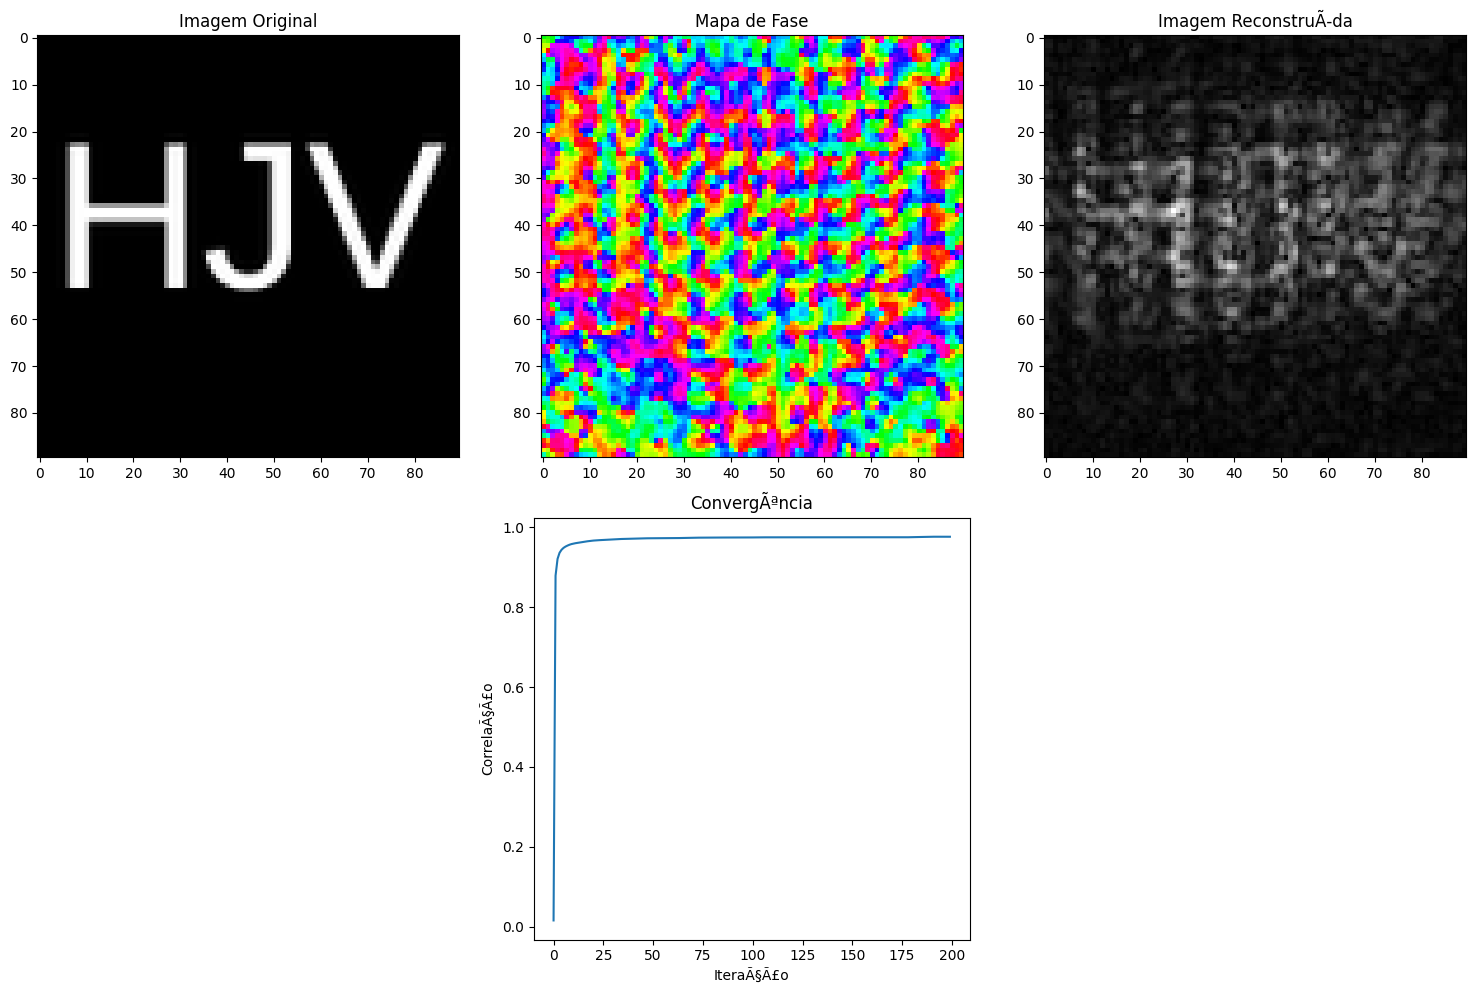

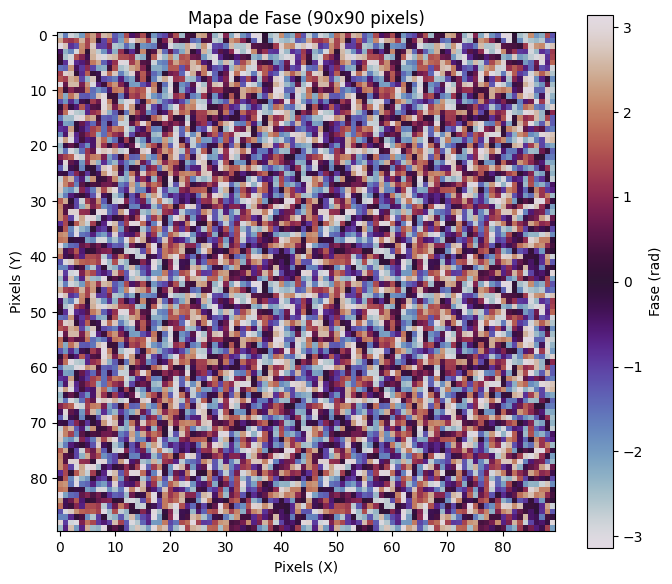

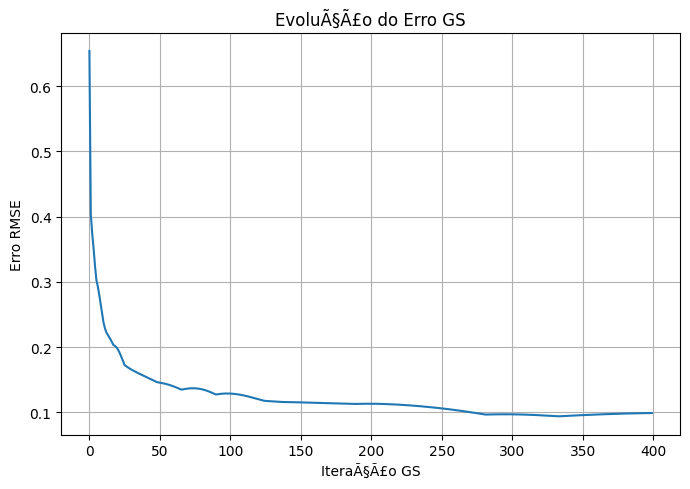

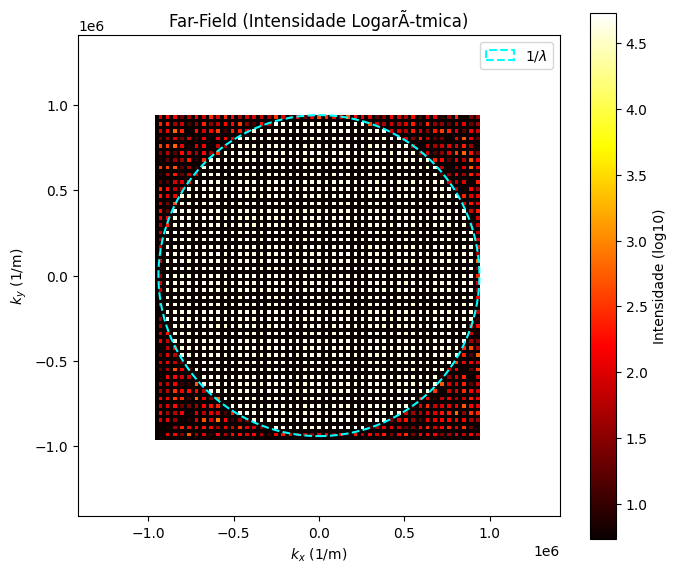

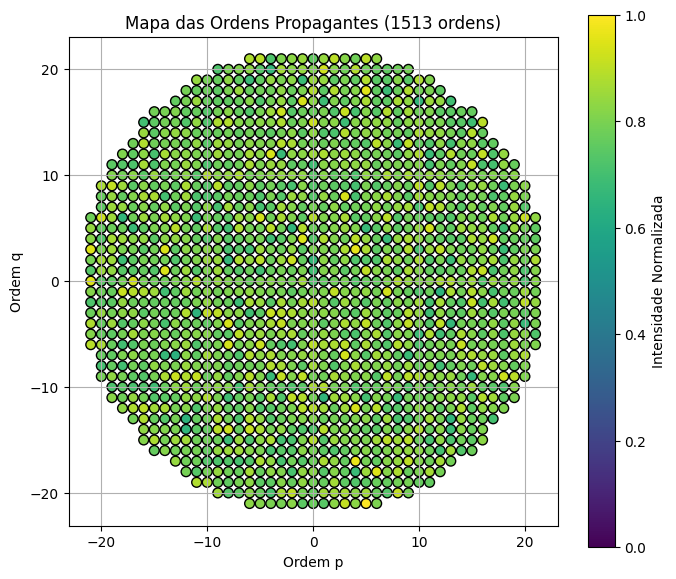

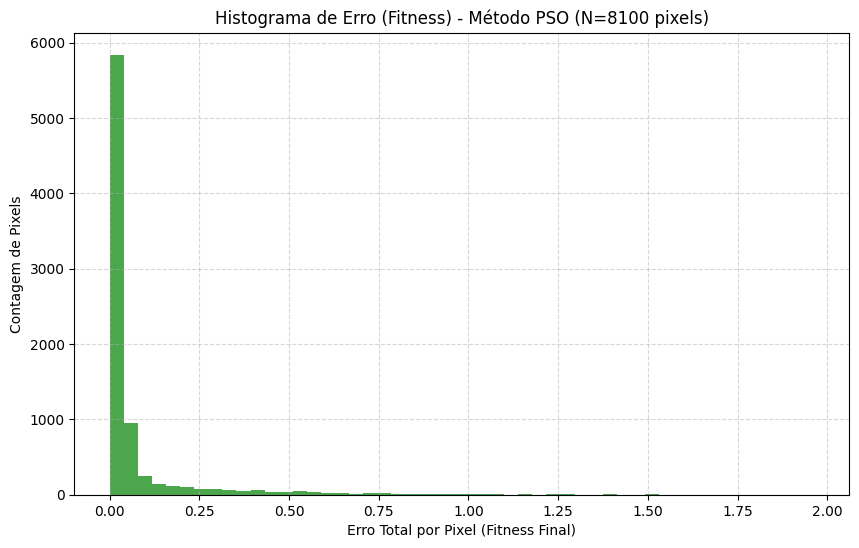

Métricas salvas com sucesso em 'optimization_metrics_pso.txt'

Verificando performance final (em lotes) da metassuperfície otimizada (PSO)...


Verificando linhas (PSO): 100%|██████████| 90/90 [00:05<00:00, 17.18it/s]


Verificação em lote (PSO) concluída.

--- Gerando Imagem da Metassuperfície Completa (PSO) ---
Isso pode demorar alguns minutos e consumir bastante RAM...


Gerando Linhas da Metassuperfície (PSO): 100%|██████████| 90/90 [00:02<00:00, 33.45it/s]


Costurando imagem final...
Imagem final gerada com dimensões: (5760, 5760)
Imagem da metassuperfície completa salva em: metasurface_completa_geometria_PSO_Teste_1_10_11_25.png

Reconstruindo imagem final a partir do campo otimizado pelo PSO...
Reconstrução final (PSO) concluída.
Gerando gráfico de comparação de reconstrução (PSO)...


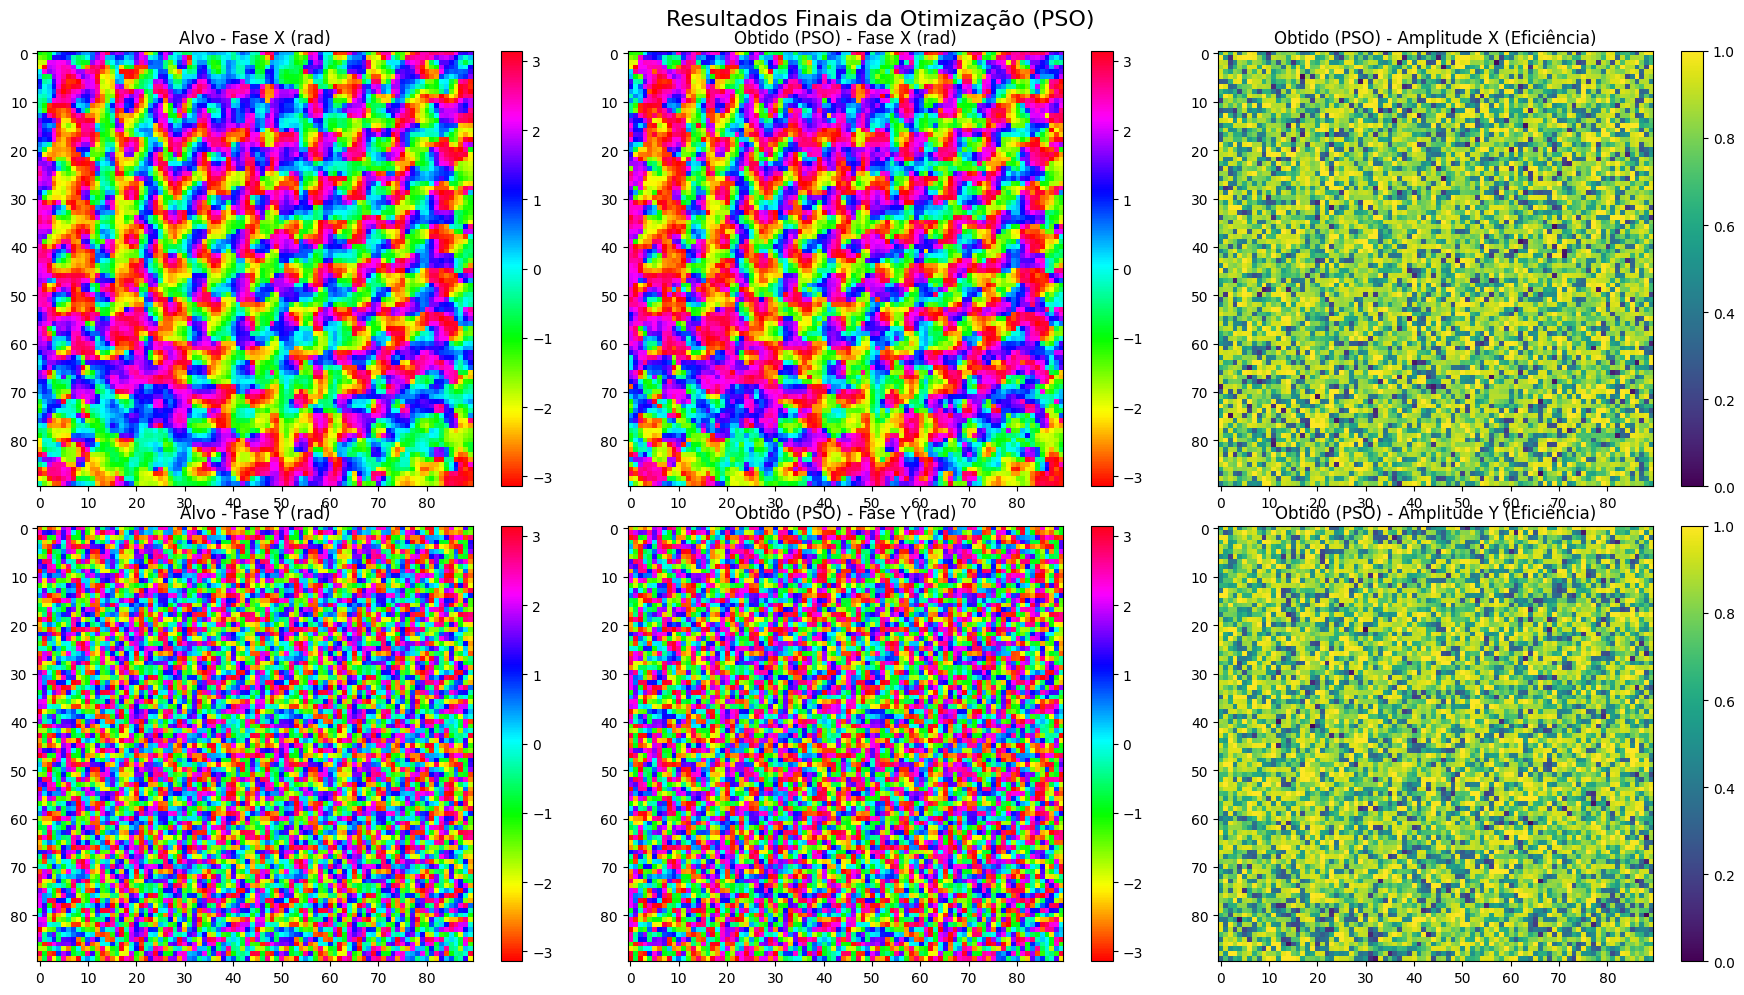

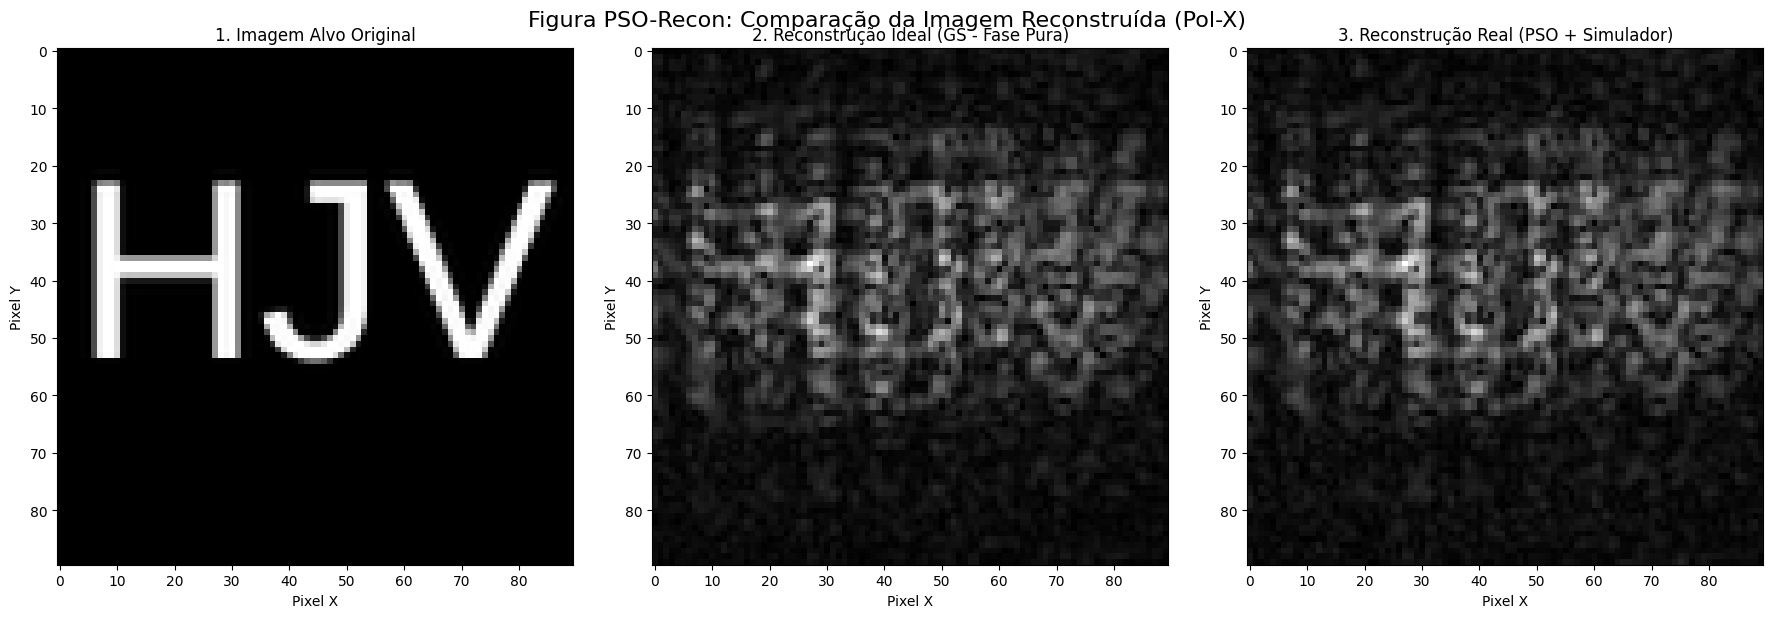

Gráfico 'comparacao_reconstrucao_PSO.png' salvo.


In [4]:

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
import time
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from tqdm import tqdm
from PIL import Image
from joblib import Parallel, delayed
from scipy.fft import fft2, ifft2, fftshift, ifftshift
from deap import base, creator, tools, algorithms

"""## Estruturas para utilizar o Simulador e o Gerador"""

class ResBlock(nn.Module):
    """
    Define um bloco ResNet bÃ¡sico
    """
    def __init__(self, in_channels, out_channels, stride=1):
        super().__init__()

        self.main_path = nn.Sequential(

            nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),

            nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(out_channels)
        )

        self.shortcut_path = nn.Sequential()

        if stride != 1 or in_channels != out_channels:
            self.shortcut_path = nn.Sequential(

                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        out = self.main_path(x) + self.shortcut_path(x)
        out = F.relu(out)
        return out

# N_OUTPUTS Ã© quantos valores se quer prever
N_OUTPUTS = 4

class ResNetSimulator(nn.Module):
    """
    ImplementaÃ§Ã£o do Simulator baseado em ResNet.
    """
    def __init__(self, in_channels=1, n_outputs=N_OUTPUTS):
        super().__init__()

        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels, 64, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True)
        )

        self.layer1 = ResBlock(64, 64, stride=1)

        self.layer2 = ResBlock(64, 128, stride=2)

        self.layer3 = ResBlock(128, 256, stride=2)

        self.layer4 = ResBlock(256, 256, stride=2)

        self.avgpool = nn.AdaptiveAvgPool2d((2, 2))

        self.head = nn.Sequential(
            nn.Linear(256 * 2 * 2, 128),
            nn.ReLU(inplace=True),
            nn.Linear(128, n_outputs)
        )

    def forward(self, x):
        out = self.conv1(x)
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.avgpool(out)
        out = out.view(out.size(0), -1)
        out = self.head(out)
        return out

class Sin(nn.Module):
    def forward(self, x): return torch.sin(x)

class Gaussian(nn.Module):
    def forward(self, x): return torch.exp(-x**2)

def make_coordinate_grid(size, device='cpu'):
    """Cria grade de coordenadas (x, y)"""
    xs = np.linspace(-1, 1, size)
    ys = np.linspace(-1, 1, size)
    xx, yy = np.meshgrid(xs, ys)

    coords = np.stack([xx.ravel(), yy.ravel()], axis=-1).astype(np.float32)
    return torch.from_numpy(coords).to(device) # shape (size*size, 2)

class CPPN_Generator(nn.Module):
    """
    Gerador CPPN. Mapeia (vetor latente 'v' + coords 'x,y,r') -> pixel.
    """
    def __init__(self, latent_dim, in_coords=2, out_channels=1, hidden_dim=64):
            super().__init__()
            self.latent_dim = latent_dim
            self.in_coords = in_coords
            self.out_channels = out_channels

            input_dim = in_coords + latent_dim

            self.net = nn.Sequential(
                nn.Linear(input_dim, hidden_dim),
                nn.Tanh(),

                nn.Linear(hidden_dim, hidden_dim),
                nn.ReLU(),

                nn.Linear(hidden_dim, hidden_dim),
                Sin(),

                nn.Linear(hidden_dim, hidden_dim),
                nn.LeakyReLU(0.2),

                nn.Linear(hidden_dim, hidden_dim),
                Gaussian(),

                nn.Linear(hidden_dim, hidden_dim),
                nn.Tanh(),

                nn.Linear(hidden_dim, hidden_dim),
                Sin(),

                nn.Linear(hidden_dim, hidden_dim),
                Gaussian(),

                nn.Linear(hidden_dim, hidden_dim),
                nn.Tanh(),

                nn.Linear(hidden_dim, hidden_dim),
                nn.ReLU(),

                nn.Linear(hidden_dim, hidden_dim),
                Sin(),

                nn.Linear(hidden_dim, out_channels),
                nn.Sigmoid()
            )

    def forward(self, coords, v):

        v_expanded = v.unsqueeze(1)
        v_tiled = v_expanded.repeat(1, coords.size(0), 1)

        coords_tiled = coords.unsqueeze(0).repeat(v.size(0), 1, 1)

        combined_input = torch.cat([coords_tiled, v_tiled], dim=-1)

        output = self.net(combined_input)

        img_size = int(np.sqrt(coords.size(0)))

        output = output.permute(0, 2, 1).view(-1, self.out_channels, img_size, img_size)

        return output

"""# Mapas de Fase

CriaÃ§Ã£o do mapa de fase para a polarizaÃ§Ã£o x:
"""

def load_and_preprocess_image(image_path, target_size=(450, 450)):
    """
    Carrega e prÃ©-processa a imagem alvo usando PIL
    """
    try:
        image = Image.open(image_path).convert('L')
        image = image.resize(target_size, Image.LANCZOS)
        image_array = np.array(image, dtype=np.float64)
        image_array = image_array / np.max(image_array)
        return image_array
    except FileNotFoundError:
        print(f"AtenÃ§Ã£o: Imagem '{image_path}' nÃ£o encontrada. Criando imagem de teste...")
        target_image = np.zeros(target_size)
        target_image[150:300, 100:200] = 1.0
        target_image[150:200, 200:350] = 1.0
        target_image[250:300, 200:350] = 1.0
        return target_image

def apply_zero_padding(image, padding_factor=2):
    """
    Aplica zero-padding Ã  imagem
    """
    original_size = image.shape
    padded_size = (image.shape[0] * padding_factor, image.shape[1] * padding_factor)
    padded_image = np.zeros(padded_size, dtype=complex)

    start_row = (padded_size[0] - original_size[0]) // 2
    start_col = (padded_size[1] - original_size[1]) // 2
    padded_image[start_row:start_row+original_size[0],
                 start_col:start_col+original_size[1]] = image

    return padded_image, original_size

def create_low_pass_filter(shape, wavelength, dx, NA):
    """
    Cria filtro passa-baixa baseado na abertura numÃ©rica
    """
    nx, ny = shape
    fx = np.fft.fftfreq(nx, dx)
    fy = np.fft.fftfreq(ny, dx)
    FX, FY = np.meshgrid(fx, fy, indexing='ij')

    f_cutoff = NA / wavelength
    freq_radius = np.sqrt(FX**2 + FY**2)
    filter_mask = (freq_radius <= f_cutoff).astype(np.float64)

    return filter_mask

def angular_spectrum_propagation(U, wavelength, z, dx, filter_mask=None):
    """
    Propaga o campo usando mÃ©todo do espectro angular
    """
    k = 2 * np.pi / wavelength
    nx, ny = U.shape

    fx = np.fft.fftfreq(nx, dx)
    fy = np.fft.fftfreq(ny, dx)
    FX, FY = np.meshgrid(fx, fy, indexing='ij')

    root_term = 1 - (wavelength * FX)**2 - (wavelength * FY)**2
    root_term[root_term < 0] = 0

    H = np.exp(1j * k * z * np.sqrt(root_term))

    if filter_mask is not None:
        H = H * filter_mask

    U_freq = fft2(U)
    U_prop_freq = U_freq * H
    U_prop = ifft2(U_prop_freq)

    return U_prop

def calculate_correlation(target, reconstructed):
    """
    Calcula a correlaÃ§Ã£o de Pearson entre duas imagens (valores reais)
    """
    target_real = np.real(target).flatten()
    reconstructed_real = np.real(reconstructed).flatten()

    correlation = np.corrcoef(target_real, reconstructed_real)[0, 1]

    if np.isnan(correlation):
        return 0.0

    return float(correlation)

def extract_center(image, original_size):
    """
    Extrai regiÃ£o central da imagem (remove padding)
    """
    nx, ny = original_size
    start_row = (image.shape[0] - nx) // 2
    start_col = (image.shape[1] - ny) // 2
    return image[start_row:start_row+nx, start_col:start_col+ny]

def reconstruct_image(phase_map, wavelength, z, dx, NA):
    """
    ReconstrÃ³i a imagem a partir do mapa de fase
    """
    # Aplica zero-padding ao mapa de fase
    phase_padded, original_size = apply_zero_padding(np.exp(1j * phase_map))

    # Cria filtro
    filter_mask = create_low_pass_filter(phase_padded.shape, wavelength, dx, NA)

    # Propaga para o plano da imagem
    reconstructed = angular_spectrum_propagation(phase_padded, wavelength, z, dx, filter_mask)

    # Extrai regiÃ£o central e pega a amplitude (np.abs)
    reconstructed = extract_center(np.abs(reconstructed), original_size)

    return np.real(reconstructed)  # Garante valor real

def reconstruct_image_from_field(complex_field, wavelength, z, dx, NA):
    """
    Reconstrói a imagem a partir de um CAMPO COMPLEXO (Amp + Fase)
    """
    # 1. Aplica zero-padding ao campo complexo
    field_padded, original_size = apply_zero_padding(complex_field)

    # 2. Cria filtro
    filter_mask = create_low_pass_filter(field_padded.shape, wavelength, dx, NA)

    # 3. Propaga para o plano da imagem
    reconstructed = angular_spectrum_propagation(field_padded, wavelength, z, dx, filter_mask)

    # 4. Extrai região central e pega a amplitude (np.abs)
    reconstructed_center = extract_center(reconstructed, original_size)
    reconstructed_amplitude = np.abs(reconstructed_center)

    return np.real(reconstructed_amplitude) # Garante valor real

def gerchberg_saxton_angular_spectrum(target, wavelength, z, dx, NA, num_iter=50):
    """
    Algoritmo de Gerchberg-Saxton com espectro angular
    Retornar a imagem original e a reconstruÃ­da
    """
    target_padded, original_size = apply_zero_padding(target)
    nx_pad, ny_pad = target_padded.shape

    filter_mask = create_low_pass_filter((nx_pad, ny_pad), wavelength, dx, NA)

    phase = np.random.rand(nx_pad, ny_pad) * 2 * np.pi
    U = target_padded * np.exp(1j * phase)

    correlations = []

    for i in range(num_iter):
        # 1. Propaga para o plano da imagem
        U_image = angular_spectrum_propagation(U, wavelength, z, dx, filter_mask)

        # 2. MantÃ©m a fase, atualiza amplitude com alvo
        amplitude_image = np.abs(U_image)
        phase_image = np.angle(U_image)

        # Calcula correlaÃ§Ã£o para monitorar convergÃªncia
        target_region = extract_center(target_padded, original_size)
        recon_region = extract_center(amplitude_image, original_size)

        corr = calculate_correlation(target_region, recon_region)
        correlations.append(corr)

        # Atualiza campo no plano da imagem
        U_image_updated = target_padded * np.exp(1j * phase_image)

        # 3. Propaga de volta para o plano do holograma
        U = angular_spectrum_propagation(U_image_updated, wavelength, -z, dx, filter_mask)

        # 4. MantÃ©m a fase, atualiza amplitude com incidente (unitÃ¡ria)
        phase_hologram = np.angle(U)
        U = np.exp(1j * phase_hologram) # Amplitude unitÃ¡ria (holograma de fase)

        if (i + 1) % 10 == 0:
            print(f" 	IteraÃ§Ã£o GS (X) {i+1}/{num_iter}, CorrelaÃ§Ã£o: {corr:.4f}")

    phase_final = extract_center(np.angle(U), original_size)

    reconstructed_image = reconstruct_image(phase_final, wavelength, z, dx, NA)

    return target, reconstructed_image, phase_final, correlations

wavelength = 1064e-9  # 1064 nm
z = 380e-6           # 380 Î¼m
dx = 520e-9          # pixel pitch
NA = 0.65            # abertura numÃ©rica
num_iter = 200       # nÃºmero de iteraÃ§Ãµes

print("Carregando e prÃ©-processando imagem...")
target_original = load_and_preprocess_image('/content/HJV.png', target_size=(90, 90))

print("Executando algoritmo de Gerchberg-Saxton...")

img_original, img_reconstruida, mapa_de_fase, correlations = gerchberg_saxton_angular_spectrum(
    target_original,
    wavelength,
    z,
    dx,
    NA,
    num_iter
)
print(f"\nCorrelaÃ§Ã£o final: {correlations[-1]:.4f}")

print(f"DimensÃµes da Imagem Original: {img_original.shape}")
print(f"DimensÃµes da Imagem ReconstruÃ­da: {img_reconstruida.shape}")
print(f"DimensÃµes do Mapa de Fase: {mapa_de_fase.shape}")

# np.savetxt('phase_map_x_polarization.txt', mapa_de_fase)
# np.savetxt('correlations.txt', correlations)

plt.figure(figsize=(15, 10))

plt.subplot(2, 3, 1)
plt.imshow(img_original, cmap='gray')
plt.title('Imagem Original')

plt.subplot(2, 3, 2)
plt.imshow(mapa_de_fase, cmap='hsv')
plt.title('Mapa de Fase')

plt.subplot(2, 3, 3)
plt.imshow(img_reconstruida, cmap='gray')
plt.title('Imagem ReconstruÃ­da')

plt.subplot(2, 3, 5)
plt.plot(correlations)
plt.title('ConvergÃªncia')
plt.xlabel('IteraÃ§Ã£o')
plt.ylabel('CorrelaÃ§Ã£o')

plt.tight_layout()
#plt.show()

"""## PolarizaÃ§Ã£o y:"""

def generate_dammann_phase_map(
    P: float = 520e-9,
    wavelength: float = 1064e-9,
    supercell_pixels: int = 45,
    n_supercells: int = 2,
    iters_gs: int = 400,
    random_seed: int = 0,
    verbose: bool = True
) -> tuple[np.ndarray, dict, list]:
    """
    Gera o mapa de fase para uma grade de Dammann (spot-cloud) usando o algoritmo GS.
    """
    np.random.seed(random_seed)

    N_super = supercell_pixels
    dx = P
    d = dx * N_super

    # --- Grade k e alvo ---
    # (Esta funÃ§Ã£o usa np.fft, o que nÃ£o conflita com o Bloco 1)
    kx = np.fft.fftfreq(N_super, d=dx)
    ky = np.fft.fftfreq(N_super, d=dx)
    kx_shift = np.fft.fftshift(kx)
    ky_shift = np.fft.fftshift(ky)
    KX, KY = np.meshgrid(kx_shift, ky_shift)
    K_rad = np.sqrt(KX**2 + KY**2)
    target_radius = min(1.0 / wavelength, 1.0 / (2.0 * dx))
    target_amp = (K_rad <= target_radius).astype(float)

    # --- Algoritmo GS ---
    plane_field = np.exp(1j * 2.0 * np.pi * np.random.rand(N_super, N_super))
    errors = []

    # Loop de iteraÃ§Ã£o para Dammann
    gs_iterator = range(iters_gs)
    if verbose:
        # Cria uma barra de progresso se 'verbose' for True
        gs_iterator = tqdm(range(iters_gs), desc="  IteraÃ§Ãµes GS (Y)", leave=False)

    for it in gs_iterator:
        far = np.fft.fft2(plane_field)
        far_shift = np.fft.fftshift(far)

        amp_current = np.abs(far_shift)
        err = np.sqrt(np.mean((amp_current / (amp_current.max() + 1e-9) - target_amp)**2))
        errors.append(err)

        far_shift = target_amp * np.exp(1j * np.angle(far_shift))
        far = np.fft.ifftshift(far_shift)

        plane_field = np.fft.ifft2(far)
        plane_field = np.exp(1j * np.angle(plane_field))

    supercell_phase = np.angle(plane_field)

    # --- ConstruÃ§Ã£o da MetassuperfÃ­cie Completa ---
    full_phase = np.tile(supercell_phase, (n_supercells, n_supercells))

    if verbose:
        print(f"  Mapa Dammann (Y) gerado: {full_phase.shape} pixels")

    metrics = {} # Vazio, focado apenas na geraÃ§Ã£o de fase

    return full_phase, metrics, errors

def analyze_and_plot_results(
    full_phase: np.ndarray,
    errors: list,
    P: float,
    wavelength: float,
    supercell_pixels: int
) -> pd.DataFrame:
    """
    Analisa e plota os resultados da metassuperfÃ­cie.
    Retorna um DataFrame com os dados das ordens propagantes.
    """

    print("Iniciando anÃ¡lise e plotagem...")

    # --- Plot 1: Mapa de Fase ---
    print("Plot 1: Gerando plot_mapa_fase.png...")
    plt.figure(figsize=(7, 6))
    plt.imshow(full_phase, cmap='twilight', extent=None)
    plt.colorbar(label="Fase (rad)")
    plt.title(f"Mapa de Fase ({full_phase.shape[0]}x{full_phase.shape[1]} pixels)")
    plt.xlabel("Pixels (X)")
    plt.ylabel("Pixels (Y)")
    plt.tight_layout()
    plt.savefig("plot_mapa_fase.png", dpi=150)

    # --- Plot 2: EvoluÃ§Ã£o do Erro ---
    print("Plot 2: Gerando plot_erro_gs.png...")
    plt.figure(figsize=(7, 5))
    plt.plot(errors)
    plt.xlabel("IteraÃ§Ã£o GS")
    plt.ylabel("Erro RMSE")
    plt.title("EvoluÃ§Ã£o do Erro GS")
    plt.grid(True)
    plt.tight_layout()
    plt.savefig("plot_erro_gs.png", dpi=150)

    # --- AnÃ¡lise de Far-Field (CÃ©lulas 8 & 9) ---
    print("AnÃ¡lise: Calculando Far-Field da metassuperfÃ­cie completa...")
    N_full = full_phase.shape[0]
    dx_full = P

    # Criar a grade k
    kx_full = np.fft.fftfreq(N_full, d=dx_full)
    ky_full = np.fft.fftfreq(N_full, d=dx_full)
    kx_full_shift = np.fft.fftshift(kx_full)
    ky_full_shift = np.fft.fftshift(ky_full)

    # Calcular o far-field
    plane_field_full = np.exp(1j * full_phase)
    far_field_full = np.fft.fft2(plane_field_full)
    far_field_full_shift = np.fft.fftshift(far_field_full)
    far_field_intensity = np.abs(far_field_full_shift)**2

    print("AnÃ¡lise: Extraindo ordens de difraÃ§Ã£o...")
    d_supercell = supercell_pixels * P
    max_order = int(np.floor((d_supercell) / wavelength))

    p_range = np.arange(-max_order, max_order + 1)
    q_range = np.arange(-max_order, max_order + 1)
    order_data = []

    for p in p_range:
        for q in q_range:
            k_p = p / d_supercell
            k_q = q / d_supercell

            idx_p = np.argmin(np.abs(kx_full_shift - k_p))
            idx_q = np.argmin(np.abs(ky_full_shift - k_q))

            k_rad_order = np.sqrt(k_p**2 + k_q**2)
            if k_rad_order <= (1.0 / wavelength):
                intensity = far_field_intensity[idx_q, idx_p]
                order_data.append({'p': p, 'q': q, 'intensity': intensity, 'k_p': k_p, 'k_q': k_q})

    df_orders = pd.DataFrame(order_data)
    print(f"AnÃ¡lise concluÃ­da. Encontradas {len(df_orders)} ordens propagantes.")

    print("Plot 3: Gerando plot_far_field.png...")
    log_intensity = np.log10(far_field_intensity + 1e-9)
    vmax_val = log_intensity.max()
    vmin_val = vmax_val - 4

    plt.figure(figsize=(7, 6))
    plt.imshow(
        log_intensity,
        cmap='hot',
        extent=[kx_full_shift.min(), kx_full_shift.max(), ky_full_shift.min(), ky_full_shift.max()],
        vmin=vmin_val,
        vmax=vmax_val,
        origin='lower'
    )

    k_max_plot = 1.0 / wavelength
    circle = plt.Circle((0, 0), k_max_plot, color='cyan', fill=False, linestyle='--', linewidth=1.5, label=r'$1/\lambda$')
    plt.gca().add_artist(circle)
    plt.legend(handles=[circle])

    plt.xlim(-k_max_plot * 1.5, k_max_plot * 1.5)
    plt.ylim(-k_max_plot * 1.5, k_max_plot * 1.5)
    plt.colorbar(label="Intensidade (log10)")
    plt.title("Far-Field (Intensidade LogarÃ­tmica)")
    plt.xlabel(r"$k_x$ (1/m)")
    plt.ylabel(r"$k_y$ (1/m)")
    plt.gca().set_aspect('equal')
    plt.tight_layout()
    plt.savefig("plot_far_field.png", dpi=150)

    print("Plot 4: Gerando plot_ordens_scatter.png...")
    if not df_orders.empty:
        plt.figure(figsize=(7, 6))
        norm_intensity = df_orders['intensity'] / (df_orders['intensity'].max() + 1e-9)

        sc = plt.scatter(df_orders['p'], df_orders['q'], c=norm_intensity, cmap='viridis', s=50, edgecolor="k", vmin=0)
        plt.colorbar(sc, label="Intensidade Normalizada")
        plt.xlabel("Ordem p")
        plt.ylabel("Ordem q")
        plt.title(f"Mapa das Ordens Propagantes ({len(df_orders)} ordens)")
        plt.grid(True)
        plt.gca().set_aspect('equal')
        plt.tight_layout()
        plt.savefig("plot_ordens_scatter.png", dpi=150)
    else:
        print("Plot 4: DataFrame de ordens vazio, pulando o scatter plot.")

    print("\nTodos os plots foram salvos como arquivos .png.")

    return df_orders

P = 520e-9
wavelength = 1064e-9
supercell_pixels = 45
n_supercells = 2
iters_gs = 400
random_seed = 0

print("Iniciando GeraÃ§Ã£o de Fase...")
full_phase, _, errors = generate_dammann_phase_map(
    P=P,
    wavelength=wavelength,
    supercell_pixels=supercell_pixels,
    n_supercells=n_supercells,
    iters_gs=iters_gs,
    random_seed=random_seed,
    verbose=True
)
print("GeraÃ§Ã£o de Fase ConcluÃ­da.")

df_ordens_propagantes = analyze_and_plot_results(
    full_phase=full_phase,
    errors=errors,
    P=P,
    wavelength=wavelength,
    supercell_pixels=supercell_pixels
)

print("\n--- Resumo das Ordens ---")
print(df_ordens_propagantes.head())

"""# Carregamento dos Modelos Treinados"""

IMG_SIZE = 64
LATENT_DIM = 128 # DimensÃ£o do vetor latente

GENERATOR_PATH = "/content/generator_teste_5_final.pth"
SIMULATOR_PATH = "/content/simulador_NG_teste_1.pth"

# --- Componentes Globais ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Carregar Gerador
try:
    generator = CPPN_Generator(latent_dim=LATENT_DIM, in_coords=2).to(device)
    generator.load_state_dict(torch.load(GENERATOR_PATH, map_location=device))
    generator.eval()
    print(f"Gerador '{GENERATOR_PATH}' carregado em {device}.")
except Exception as e:
    print(f"Erro ao carregar Gerador: {e}")
    exit()

# Carregar Simulador
try:
    # Use a arquitetura ResNet que vocÃª definiu (ex: ResNet-18)
    simulator = ResNetSimulator(in_channels=1, n_outputs=4).to(device)
    simulator.load_state_dict(torch.load(SIMULATOR_PATH, map_location=device))
    simulator.eval()
    print(f"Simulador '{SIMULATOR_PATH}' carregado em {device}.")
except Exception as e:
    print(f"Erro ao carregar Simulador: {e}")
    exit()

# Criar a grade de coordenadas (apenas uma vez)
def make_coordinate_grid(size, dev):
    xs = np.linspace(-1, 1, size)
    ys = np.linspace(-1, 1, size)
    xx, yy = np.meshgrid(xs, ys)
    coords = np.stack([xx.ravel(), yy.ravel()], axis=-1).astype(np.float32)
    return torch.from_numpy(coords).to(dev)

coords_grid = make_coordinate_grid(IMG_SIZE, device)
print("Grade de coordenadas criada.")
# ===========================================================================
#
# COPIE E COLE TUDO A PARTIR DESTE PONTO,
# SUBSTITUINDO A SEÇÃO "Algoritmo Genético" E TUDO O QUE VEM DEPOIS.
#
# ===========================================================================

"""# Algoritmo PSO (Particle Swarm Optimization)"""

# ---------------------------------------------------------------------------
# Configurações globais
# ---------------------------------------------------------------------------
POP_SIZE = 50         # Tamanho do enxame (número de partículas)
NGEN = 50             # Número de gerações (iterações)
BATCH_EVAL = 256      # Batch para avaliação em GPU
N_JOBS = -1           # Usa todos os núcleos da CPU

LATENT_DIM_PSO = 128 # Dimensão do vetor latente

# --- Parâmetros do PSO ---
W = 0.729  # Inércia (valor comum)
C1 = 1.494 # Coeficiente cognitivo (pbest)
C2 = 1.494 # Coeficiente social (gbest)
V_MAX = 0.5  # Velocidade máxima (50% do range por passo)
V_MIN = -0.5
BOUND_L = -1.0 # Limite inferior da posição
BOUND_H = 1.0 # Limite superior da posição

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

torch.set_num_threads(1)
os.environ["OMP_NUM_THREADS"] = "1"

# ---------------------------------------------------------------------------
# Inicialização de classes DEAP (só uma vez!)
# ---------------------------------------------------------------------------
# Limpa definições anteriores se existirem (bom para Colab)
if "FitnessMin" in creator.__dict__:
    del creator.FitnessMin
if "Particle" in creator.__dict__:
    del creator.Particle
if "Swarm" in creator.__dict__:
    del creator.Swarm

creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
creator.create("Particle", list, fitness=creator.FitnessMin, speed=list, pbest=list)
creator.create("Swarm", list)

toolbox = base.Toolbox()

# Função para inicializar uma partícula (posição e velocidade)
def initParticle(pcls, fitness, size, vmin, vmax):
    # Posição inicial
    part = pcls(np.random.uniform(BOUND_L, BOUND_H) for _ in range(size))
    # Velocidade inicial
    part.speed = [np.random.uniform(vmin, vmax) for _ in range(size)]
    # Pbest inicial é a própria posição
    part.pbest = pcls(part)
    part.pbest.fitness = fitness() # Fitness do pbest (inicialmente inválido)
    return part

toolbox.register("particle", initParticle, creator.Particle, creator.FitnessMin, LATENT_DIM_PSO, V_MIN, V_MAX)
toolbox.register("swarm", tools.initRepeat, creator.Swarm, toolbox.particle)

# ---------------------------------------------------------------------------
# Funções auxiliares (PSO)
# ---------------------------------------------------------------------------

def updateParticle(part, gbest, w, c1, c2, vmin, vmax, b_low, b_high):
    """
    Atualiza a velocidade e a posição de uma partícula (vetorizado com numpy).
    """
    dim = len(part)
    r1 = np.random.rand(dim)
    r2 = np.random.rand(dim)

    # Converte para numpy para operações vetorizadas
    np_pos = np.array(part)
    np_pbest = np.array(part.pbest)
    np_gbest = np.array(gbest)
    np_speed = np.array(part.speed)

    # Atualiza velocidade (equação padrão do PSO)
    v_inertia = w * np_speed
    v_cognitive = c1 * r1 * (np_pbest - np_pos)
    v_social = c2 * r2 * (np_gbest - np_pos)

    new_speed = v_inertia + v_cognitive + v_social
    new_speed = np.clip(new_speed, vmin, vmax) # Limita a velocidade

    # Atualiza posição
    new_pos = np_pos + new_speed
    new_pos = np.clip(new_pos, b_low, b_high) # Limita a posição

    # Atualiza a partícula (que é uma lista)
    part[:] = new_pos.tolist()
    part.speed[:] = new_speed.tolist()

# --- A FUNÇÃO DE AVALIAÇÃO É EXATAMENTE A MESMA ---
# (Ela funciona para qualquer lista de indivíduos/partículas)
def evaluate_population_batch(population, generator, simulator, phase_x, phase_y, coords_grid_tensor, latent_dim):
    """
    Avaliação vetorizada em GPU (IDÊNTICA à versão GA).
    'population' aqui será o 'swarm'.
    """
    with torch.no_grad():
        latents = torch.tensor(population, dtype=torch.float32, device=device)

        imgs = generator(coords_grid_tensor, latents)

        outputs_raw = simulator(imgs)

        # Assumindo: [0]=TE_real, [1]=TE_imag, [2]=TM_real, [3]=TM_imag
        # (Ajuste se a ordem for outra)
        s_tm_real = outputs_raw[:, 0] # Y-pol (TM)
        s_tm_imag = outputs_raw[:, 1] # Y-pol (TM)
        s_te_real = outputs_raw[:, 2] # X-pol (TE)
        s_te_imag = outputs_raw[:, 3] # X-pol (TE)

        sim_phase_x = torch.atan2(s_te_imag, s_te_real)
        sim_phase_y = torch.atan2(s_tm_imag, s_tm_real)

        target_phase_x = torch.full_like(sim_phase_x, phase_x)
        target_phase_y = torch.full_like(sim_phase_y, phase_y)

        error_x = torch.abs(sim_phase_x - target_phase_x)
        error_y = torch.abs(sim_phase_y - target_phase_y)

        # Corrige o wrapping
        pi_tensor = torch.tensor(2 * np.pi, device=device)
        error_x = torch.min(error_x, pi_tensor - error_x)
        error_y = torch.min(error_y, pi_tensor - error_y)

        errors = (error_x + error_y).detach().cpu().numpy().tolist()
        return errors


def optimize_pixel_pso(i, j, phase_x, phase_y, generator, simulator, coords_grid_tensor, latent_dim):
    """
    Otimiza o vetor latente para um pixel (i,j) usando PSO.
    """
    # 1. Inicializa o enxame
    swarm = toolbox.swarm(n=POP_SIZE)

    # Inicializa o 'gbest' (melhor global)
    gbest = None
    gbest_fitness = np.inf

    # Coleta de estatísticas (para o arquivo de métricas)
    stats_log = []

    for gen in range(NGEN):
        # 2. Avalia todas as partículas em lotes
        fitness_values = []
        for batch_start in range(0, len(swarm), BATCH_EVAL):
            batch = swarm[batch_start:batch_start + BATCH_EVAL]
            batch_values = evaluate_population_batch(
                batch, generator, simulator,
                phase_x, phase_y,
                coords_grid_tensor, latent_dim
            )
            fitness_values.extend(batch_values)

        # 3. Atualiza pbest e gbest
        for part, fit in zip(swarm, fitness_values):
            part.fitness.values = (fit,)

            # Atualiza pbest (melhor da partícula)
            if not part.pbest.fitness.valid or fit < part.pbest.fitness.values[0]:
                part.pbest[:] = part # Salva a posição
                part.pbest.fitness.values = (fit,)

            # Atualiza gbest (melhor global)
            if fit < gbest_fitness:
                gbest_fitness = fit
                gbest = toolbox.clone(part) # CLONA, não referencia

        # Coleta estatísticas da Geração 0
        if gen == 0:
            fits = [f for f in fitness_values]
            stats_log.append(np.mean(fits)) # Fitness médio inicial

        # 4. Atualiza velocidade e posição de todas as partículas
        for part in swarm:
            updateParticle(part, gbest, W, C1, C2, V_MIN, V_MAX, BOUND_L, BOUND_H)

        # Monitoramento
        if (gen + 1) % 10 == 0:
            print(f"  Pixel ({i},{j}) | Geração {gen+1}/{NGEN} | Fitness: {gbest_fitness:.4f}")

    # Adiciona fitness final ao log
    stats_log.append(gbest_fitness)

    # Retorna o melhor indivíduo e as estatísticas
    return i, j, np.array(gbest, dtype=np.float32), stats_log

"""Loop principal:"""

# ---------------------------------------------------------------
# 1. Mapas de fase alvo
# ---------------------------------------------------------------
phase_map_x = mapa_de_fase # da seção GS
phase_map_y = full_phase # da seção Dammann

rows, cols = phase_map_x.shape

# !!! CORREÇÃO: Usar a dimensão do PSO
latent_dim = LATENT_DIM_PSO

# !!! CORREÇÃO: Passar a grade de coordenadas para a função de otimização
# (A 'coords_grid' foi criada na seção "Carregamento dos Modelos")
coords_grid_tensor = coords_grid

# ---------------------------------------------------------------
# 2. Caminhos de salvamento (Alterados para PSO)
# ---------------------------------------------------------------
save_dir = "resultados_otimizacao_pso"
os.makedirs(save_dir, exist_ok=True)

latent_vectors_path = os.path.join(save_dir, "latent_vectors_optimized_pso.npy")
checkpoint_dir = os.path.join(save_dir, "checkpoints")
os.makedirs(checkpoint_dir, exist_ok=True)

# ---------------------------------------------------------------
# 3. Execução em blocos
# ---------------------------------------------------------------

BATCH_PIXELS = 128 # número de pixels otimizados em paralelo
pixel_coords = [(i, j) for i in range(rows) for j in range(cols)]

latent_vectors = np.zeros((rows, cols, latent_dim), dtype=np.float32)

# Listas para coletar métricas
all_initial_avg_fitness = []
all_best_fitness = []

print(f"\n⚙️ Iniciando otimização PSO em {rows}x{cols} pixels ({rows*cols} totais)...\n")
start_time = time.time()

for batch_start in range(0, len(pixel_coords), BATCH_PIXELS):
    batch_coords = pixel_coords[batch_start:batch_start + BATCH_PIXELS]

    print(f"🧬 Otimizando pixels {batch_start + 1}–{batch_start + len(batch_coords)} / {len(pixel_coords)}")

    # --- MUDANÇA AQUI ---
    results = Parallel(n_jobs=-1, backend="loky")(
        delayed(optimize_pixel_pso)( # Chama a função PSO
            i, j,
            phase_map_x[i, j],
            phase_map_y[i, j],
            generator, simulator,
            coords_grid_tensor, # Passando a grade de coordenadas
            latent_dim
        ) for (i, j) in batch_coords
    )

    # Salva resultados e métricas
    for i, j, vec, stats in results:
        latent_vectors[i, j, :] = vec
        all_initial_avg_fitness.append(stats[0]) # Fitness médio inicial
        all_best_fitness.append(stats[1])     # Fitness final

    # Salva progresso geral (checkpoint de matriz completa)
    np.save(latent_vectors_path, latent_vectors)
    print(f"✅ Progresso salvo ({batch_start + len(batch_coords)} pixels concluídos)\n")

# ---------------------------------------------------------------
# 5. Resultado final
# ---------------------------------------------------------------
total_execution_time = time.time() - start_time
# NFE em PSO é NGEN * POP_SIZE
total_nfe = len(pixel_coords) * POP_SIZE * NGEN

np.save(latent_vectors_path, latent_vectors)
print(f"\n🎉 Otimização PSO concluída! Resultados salvos em:\n{latent_vectors_path}\n")
print(f"Tempo total: {total_execution_time:.2f} s")

"""# Cálculo e Salvamento de Métricas (PSO)"""

print("\nCalculando métricas finais da otimização (PSO)...")

num_pixels = rows * cols

# Converter para numpy array para estatísticas fáceis
fitness_array = np.array(all_best_fitness)

# --- Bloco de Plot/Save para PSO ---

# 1. Salvar os dados do erro para comparação posterior
np.save('pso_errors.npy', fitness_array)

# 2. Gerar o histograma apenas do PSO
print("Gerando histograma de erros do PSO...")
plt.figure(figsize=(10, 6))
plt.hist(fitness_array, bins=50, alpha=0.7, color='green') # Cor mudada para verde
plt.title(f'Histograma de Erro (Fitness) - Método PSO (N={len(fitness_array)} pixels)')
plt.xlabel('Erro Total por Pixel (Fitness Final)')
plt.ylabel('Contagem de Pixels')
plt.grid(True, linestyle='--', alpha=0.5)
plt.savefig('histograma_PSO.png', dpi=150)
plt.show()

# ----------------------------

# 1. Melhor Valor (Best Fitness) / Erro Médio
mean_error = np.mean(fitness_array)
min_best_fitness = np.min(fitness_array)

# 2. Desvio Padrão (Standard Deviation)
std_dev_fitness = np.std(fitness_array)

# 3. Taxa de Sucesso (Success Rate)
SUCCESS_THRESHOLD = 0.1
successful_pixels = np.sum(fitness_array < SUCCESS_THRESHOLD)
success_rate = (successful_pixels / num_pixels) * 100

# 4. Convergência (Convergence Rate)
avg_initial_fitness = np.mean(all_initial_avg_fitness)
avg_final_fitness = mean_error
convergence_improvement = (avg_initial_fitness - avg_final_fitness)

# --- Criar o arquivo .txt (com nome PSO) ---
metrics_filename = "optimization_metrics_pso.txt"
try:
    with open(metrics_filename, "w", encoding="utf-8") as f:
        f.write("--- Métricas da Otimização PSO da Metassuperfície ---\n\n")
        f.write(f"Parâmetros do PSO:\n")
        f.write(f"  Tamanho do Enxame (por pixel): {POP_SIZE}\n")
        f.write(f"  Número de Gerações (por pixel): {NGEN}\n")
        f.write(f"  W (Inércia): {W}\n")
        f.write(f"  C1 (Cognitivo): {C1}\n")
        f.write(f"  C2 (Social): {C2}\n")
        f.write(f"  Total de Meta-Átomos Otimizados: {num_pixels} ({rows}x{cols})\n\n")

        f.write("--- Performance Computacional ---\n")
        f.write(f"Tempo de Execução Total: {total_execution_time:.2f} segundos\n")
        f.write(f"Número Total de Avaliações (NFE): {total_nfe}\n")
        f.write(f"NFE por pixel (média): {total_nfe / num_pixels:.1f}\n\n")

        f.write("--- Qualidade da Otimização (Fitness/Erro) ---\n")
        f.write(f"Erro Médio Final (Média do Best Fitness): {mean_error:.6f}\n")
        f.write(f"Melhor Fitness Individual (pixel único): {min_best_fitness:.6f}\n")
        f.write(f"Desvio Padrão (Fitness): {std_dev_fitness:.6f}\n\n")

        f.write("--- Métricas de Convergência ---\n")
        f.write(f"Erro Médio Inicial (Média da Pop. Gen 0): {avg_initial_fitness:.6f}\n")
        f.write(f"Melhoria Média (Inicial - Final): {convergence_improvement:.6f}\n")
        f.write(f"Taxa de Sucesso (Erro < {SUCCESS_THRESHOLD}): {success_rate:.2f} %\n")

    print(f"Métricas salvas com sucesso em '{metrics_filename}'")

except Exception as e:
    print(f"Erro ao salvar arquivo de métricas: {e}")

"""# Verificação de Performance"""

print("\nVerificando performance final (em lotes) da metassuperfície otimizada (PSO)...")

# Inicializa os arrays
final_phase_x = np.zeros((rows, cols))
final_phase_y = np.zeros((rows, cols))
final_amp_x = np.zeros((rows, cols))
final_amp_y = np.zeros((rows, cols))

# Usa a grade de coordenadas global
coords_grid_tensor = coords_grid

with torch.no_grad():
    for i in tqdm(range(rows), desc="Verificando linhas (PSO)"):

        z_row_list = [latent_vectors[i, j] for j in range(cols)]
        z_row_tensor = torch.from_numpy(np.array(z_row_list)).float().to(device)

        imgs_batch = generator(coords_grid_tensor, z_row_tensor)
        imgs_binary_batch = (imgs_batch > 0.5).float()

        outputs_raw = simulator(imgs_binary_batch)

        s_tm_real = outputs_raw[:, 0]
        s_tm_imag = outputs_raw[:, 1]
        s_te_real = outputs_raw[:, 2]
        s_te_imag = outputs_raw[:, 3]

        s_te_complex = torch.complex(s_te_real, s_te_imag)
        s_tm_complex = torch.complex(s_tm_real, s_tm_imag)

        final_phase_x[i, :] = torch.angle(s_te_complex).cpu().numpy()
        final_amp_x[i, :] = torch.abs(s_te_complex).cpu().numpy()
        final_phase_y[i, :] = torch.angle(s_tm_complex).cpu().numpy()
        final_amp_y[i, :] = torch.abs(s_tm_complex).cpu().numpy()

print("Verificação em lote (PSO) concluída.")

# --- Plotar resultados (com nome PSO) ---
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
plt.suptitle("Resultados Finais da Otimização (PSO)", fontsize=16)

# Coluna 1: Alvos
im0 = axes[0, 0].imshow(phase_map_x, cmap='hsv', vmin=-np.pi, vmax=np.pi)
axes[0, 0].set_title("Alvo - Fase X (rad)")
fig.colorbar(im0, ax=axes[0, 0])

im1 = axes[1, 0].imshow(phase_map_y, cmap='hsv', vmin=-np.pi, vmax=np.pi)
axes[1, 0].set_title("Alvo - Fase Y (rad)")
fig.colorbar(im1, ax=axes[1, 0])

# Coluna 2: Fases Obtidas
im2 = axes[0, 1].imshow(final_phase_x, cmap='hsv', vmin=-np.pi, vmax=np.pi)
axes[0, 1].set_title("Obtido (PSO) - Fase X (rad)")
fig.colorbar(im2, ax=axes[0, 1])

im3 = axes[1, 1].imshow(final_phase_y, cmap='hsv', vmin=-np.pi, vmax=np.pi)
axes[1, 1].set_title("Obtido (PSO) - Fase Y (rad)")
fig.colorbar(im3, ax=axes[1, 1])

# Coluna 3: Amplitudes Obtidas
im4 = axes[0, 2].imshow(final_amp_x, cmap='viridis', vmin=0, vmax=1)
axes[0, 2].set_title("Obtido (PSO) - Amplitude X (Eficiência)")
fig.colorbar(im4, ax=axes[0, 2])

im5 = axes[1, 2].imshow(final_amp_y, cmap='viridis', vmin=0, vmax=1)
axes[1, 2].set_title("Obtido (PSO) - Amplitude Y (Eficiência)")
fig.colorbar(im5, ax=axes[1, 2])

plt.tight_layout()

plt.savefig("Resultados_Otimizacao_PSO_Teste_1_09_11_25.png", dpi=300, bbox_inches="tight")

#plt.show()

print("\n--- Gerando Imagem da Metassuperfície Completa (PSO) ---")
print("Isso pode demorar alguns minutos e consumir bastante RAM...")

try:
    rows, cols = latent_vectors.shape[0], latent_vectors.shape[1]
    img_size = IMG_SIZE
    full_surface_rows_list = []

    for i in tqdm(range(rows), desc="Gerando Linhas da Metassuperfície (PSO)"):

        z_row_list = [latent_vectors[i, j] for j in range(cols)]
        z_row_tensor = torch.from_numpy(np.array(z_row_list)).float().to(device)

        with torch.no_grad():
            img_row_batch = generator(coords_grid, z_row_tensor)
            img_row_binary = (img_row_batch > 0.5).float()

        img_row_binary = img_row_binary.squeeze(1)
        img_row_binary = img_row_binary.transpose(0, 1)
        final_row_img = img_row_binary.reshape(img_size, -1)

        full_surface_rows_list.append(final_row_img.cpu().numpy())

    print("Costurando imagem final...")
    final_metasurface_image = np.concatenate(full_surface_rows_list, axis=0)

    print(f"Imagem final gerada com dimensões: {final_metasurface_image.shape}")

    # Salva com nome PSO
    output_filename = "metasurface_completa_geometria_PSO_Teste_1_10_11_25.png"
    plt.imsave(output_filename, final_metasurface_image, cmap='gray')
    print(f"Imagem da metassuperfície completa salva em: {output_filename}")

except Exception as e:
    print(f"Ocorreu um erro ao gerar a metassuperfície completa: {e}")


# --- BLOCO FINAL DE RECONSTRUÇÃO (Adaptado para PSO) ---

print("\nReconstruindo imagem final a partir do campo otimizado pelo PSO...")

# Criar o campo complexo para Pol-X (Holograma)
campo_complexo_x_final_pso = final_amp_x * np.exp(1j * final_phase_x)

# Usar os mesmos parâmetros do GS
img_reconstruida_final_pso = reconstruct_image_from_field(
    campo_complexo_x_final_pso,
    wavelength,
    z,
    dx,
    NA
)
print("Reconstrução final (PSO) concluída.")


print("Gerando gráfico de comparação de reconstrução (PSO)...")

fig_pso_recon = plt.figure(figsize=(18, 6))
plt.suptitle("Figura PSO-Recon: Comparação da Imagem Reconstruída (Pol-X)", fontsize=16)

# Painel 1: Imagem Alvo Original
plt.subplot(1, 3, 1)
plt.imshow(img_original, cmap='gray')
plt.title("1. Imagem Alvo Original")
plt.xlabel("Pixel X")
plt.ylabel("Pixel Y")

# Painel 2: Reconstrução Ideal (do GS, Fase Pura)
plt.subplot(1, 3, 2)
plt.imshow(img_reconstruida, cmap='gray')
plt.title("2. Reconstrução Ideal (GS - Fase Pura)")
plt.xlabel("Pixel X")
plt.ylabel("Pixel Y")

# Painel 3: Reconstrução Real (do PSO + Simulador)
plt.subplot(1, 3, 3)
plt.imshow(img_reconstruida_final_pso, cmap='gray')
plt.title("3. Reconstrução Real (PSO + Simulador)")
plt.xlabel("Pixel X")
plt.ylabel("Pixel Y")

plt.tight_layout()
plt.savefig("comparacao_reconstrucao_PSO.png", dpi=300, bbox_inches='tight')
plt.show()

print("Gráfico 'comparacao_reconstrucao_PSO.png' salvo.")